In [4]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
# !pip install xlrd
# import xlrd

We first load the dataset from the .xls file (downloaded from https://archive.ics.uci.edu/ml/machine-learning-databases/00350/)

In [5]:
data_df=pd.read_excel('default.xls')
data_df.dropna(inplace=True)
print(data_df.shape)
data_np = data_df.to_numpy()
print(data_np[0])
data_np = data_np[1:,1:]
np.random.seed(0)
data_np = np.random.permutation(data_np)

(30001, 25)
['ID' 'LIMIT_BAL' 'SEX' 'EDUCATION' 'MARRIAGE' 'AGE' 'PAY_0' 'PAY_2'
 'PAY_3' 'PAY_4' 'PAY_5' 'PAY_6' 'BILL_AMT1' 'BILL_AMT2' 'BILL_AMT3'
 'BILL_AMT4' 'BILL_AMT5' 'BILL_AMT6' 'PAY_AMT1' 'PAY_AMT2' 'PAY_AMT3'
 'PAY_AMT4' 'PAY_AMT5' 'PAY_AMT6' 'default payment next month']


Now we want to check if the data is balanced with respect to the target value, i.e., default payment next month:

In [6]:
target = data_np[:,23]
print(target.sum())

6636


Here we clearly identiy only 6636 out of 30000 (around 22%) of clients will default next month. Thus we want to split the data carefully such that this ratio is mantained across training and test data.

Next we aplit the dataset to training (20000 instances) and test (10000 instances). Thus we need to have (6636*2)/3=4424 positive samples and 15576 negative samples in training set:

In [7]:
train_np = []
test_np = []
pos_count = 0
for sample in data_np:
    if len(train_np)==20000:
        test_np.append(sample)
    else:
        if sample[23]==1:
            if pos_count<4424:
                train_np.append(sample)
            else:
                test_np.append(sample)
            pos_count+=1
        else:
            train_np.append(sample)
    
train_np = np.array(train_np)
test_np = np.array(test_np)

Then we verify the correctness of such split:

In [8]:
print(train_np.shape)
print(train_np[:,23].sum())
print(test_np.shape)
print(test_np[:,23].sum())

(20000, 24)
4363
(10000, 24)
2273


Finally, we save the data split using pickle

In [9]:
import pickle
with open("train_test_split.pkl", "bw") as fh:
    data = (train_np, test_np)
    pickle.dump(data, fh)

Loading the data

In [10]:
with open("train_test_split.pkl", "br") as fh:
    data = pickle.load(fh)
train_data = data[0]
test_data = data[1]

train_x = train_data[:,:23] 
train_y = train_data[:,23] # labels are either 0 or 1 
test_x = test_data[:,:23]
test_y = test_data[:,23] # labels are either 0 or 1
# print(train_x.shape)

Finding d optimal weak classifiers

In [11]:
def split_error(XY, weights, threshold, sign):
    y_pred = [(sign*x_i > -threshold) for x_i in XY[:,0]]
    return np.sum(weights[y_pred != XY[:,1]])

def potential_split(XY, index):
    # suppose the feature changes at this index from value 1 to value 2 (datapoint index-1 has val1, index has val2)
    value1 = XY[XY[:,0] == XY[index-1,0]] # all the labels for examples where the feature takes the value 1
    value2 = XY[XY[:,0] == XY[index,0]] # all the labels for examples where the feature takes the value 2
    if len(np.union1d(np.unique(value1[:,1]), np.unique(value2[:,1]))) == 2: # not all labels are the same
        return True
    return False

def get_weak_classifiers(data_x, data_y):
    # returns array of d weak classifiers
    n, d = data_x.shape
    P = np.ones(data_y.shape) * 1/data_y.shape[0]
    weak_classifiers = [] # will hold the final j weak learners
    for j in tqdm_notebook(range(d)):
        # keep only feature j and labels
        feature = train_data[:, [j, 23]]
        feature = feature[feature[:, 0].argsort()]
        potential_h = [] # each row is (threshold, sign, training error)
        for i in range(n):
            if feature[i,0] != feature[i-1,0]:
                # check if division makes sense
                if not potential_split(feature, i):
                    continue
                th = (feature[i,0] + feature[i-1,0]) / 2
                err = split_error(feature, P, th, 1)
                if err > 0.5: # flip
                    potential_h.append((-th, -1, 1 - err))
                else:
                    potential_h.append((th, 1, err))
        potential_h = np.array(potential_h)
        # array of indexes of all thresholds that give minimum error
        good_h = np.where(potential_h[:,2] == np.min(potential_h[:,2]))[0]
        med_val = np.median(potential_h[good_h,0])
        weak_classifiers.append((med_val, potential_h[good_h[0],1], potential_h[good_h[0],2]))

    return np.array(weak_classifiers)

H = get_weak_classifiers(train_x, train_y)

  0%|          | 0/23 [00:00<?, ?it/s]

Run classifiers on test data:

In [12]:
def test_weak_classifiers(weak_classifiers, data_full):
    errors = []
    n, d = data_full.shape
    d -= 1
    P = np.ones((n,1)) * 1/n    # uniform
    for j in range(d):
        feature = data_full[:, [j, 23]]
        feature = feature[feature[:, 0].argsort()]
        errors.append(split_error(feature, P, weak_classifiers[j, 0], weak_classifiers[j, 1]))
    return np.array(errors), np.argmin(errors), np.argmax(errors)

h_test_errors, best_h, worst_h = test_weak_classifiers(H, test_data)
h_train_errors = test_weak_classifiers(H, train_data)[0]

print(f"Feature {best_h+1} achieves the best test error at {h_test_errors[best_h]:.3f}, with training error {h_train_errors[best_h]:.3f} and sj={H[best_h, 1]:.0f}, bj={H[best_h, 0]:.3f}\n")

print(f"Feature {worst_h+1} achieves the worst test error at {h_test_errors[worst_h]:.3f}, with training error {h_train_errors[worst_h]:.3f} and sj={H[worst_h, 1]:.0f}, bj={H[worst_h, 0]:.3f}\n")

print(f"Average test error: {np.average(h_test_errors):.3f}")
print(f"Average train error: {np.average(h_train_errors):.3f}")

Feature 6 achieves the best test error at 0.189, with training error 0.176 and sj=1, bj=-1.500

Feature 14 achieves the worst test error at 0.228, with training error 0.218 and sj=-1, bj=-21056.500

Average test error: 0.223
Average train error: 0.214


### Exercise 3.3: Parallel Adaboost

Creating matrix M:

In [13]:
def hypothesis(weak_learners: np.array, j: int, X: np.array) -> {-1,1}:
    sign = weak_learners[j,1]
    b = weak_learners[j,0]
    return np.sign(sign * X[j] + b)

def get_M(weak_learners, data_X, data_y):
    data_y[data_y==0] = -1
    M = np.empty(data_X.shape)
    for I, (x, y) in enumerate(zip(data_X, data_y)):
        for J, h in enumerate(weak_learners):
            M[I, J] = y * hypothesis(H, J, x)
    return M

M_matrix = get_M(H, train_x, train_y)

Parallel Adaboost:

In [14]:
def metaclassifier(weak_classifiers: np.array, W: np.array, X: np.array) -> {-1,1}:
    weighted_sum = 0
    for j, w in enumerate(W):
        weighted_sum += w * hypothesis(weak_classifiers, j, X)
    return np.sign(weighted_sum)

def adaboost_error(weights, weak_classifiers, data_X, data_y):
    weighted_sum = 0
    data_y[data_y==0] = -1
    for X, y in zip(data_X, data_y):
        weighted_sum += (y * metaclassifier(weak_classifiers, weights, X) <= 0)
    return weighted_sum / data_y.shape[0]

def Parallel_Adaboost(M: np.ndarray, max_pass=100) -> np.array:
    M = M/M.shape[1]
    train_errors = np.empty(max_pass)
    test_errors = np.empty(max_pass)
    training_loss = np.empty(max_pass)
    n, d = M.shape
    P = np.ones((n, 1))
    W = np.zeros((d, 1))
    for t in tqdm_notebook(range(max_pass)):
        P = P / np.sum(P)
        E = np.matmul(np.negative(np.transpose(M).clip(max=0)), P)
        G = np.matmul(np.transpose(M).clip(min=0), P)
        B = 0.5 * (np.log(G) - np.log(E))
        W = W + B
        P = np.multiply(P, np.exp(np.matmul(-M, B)))
        train_errors[t] = adaboost_error(W, H, train_x, train_y)
        test_errors[t] = adaboost_error(W, H, test_x, test_y)
        # print(f"Iteration {t}, train error: {train_errors[t]}, test error: {test_errors[t]}")
        training_loss[t] = np.sum(np.exp(np.matmul(-M,W)))
    return W, train_errors, test_errors, training_loss

Running Parallel Adaboost:

In [15]:
T = 100
W_parallel, p_errors_train, p_errors_test, p_loss =  Parallel_Adaboost(M_matrix, T)

  0%|          | 0/100 [00:00<?, ?it/s]

Plotting errors:

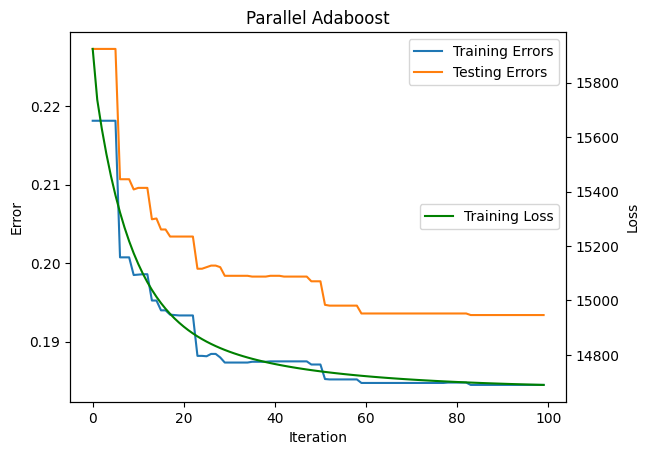

In [16]:
fig, ax = plt.subplots()
ax.plot(p_errors_train, label="Training Errors")
ax.plot(p_errors_test, label="Testing Errors")
ax.set_xlabel("Iteration")
ax.set_ylabel("Error")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(p_loss, label="Training Loss", color="green")
ax2.set_ylabel("Loss")
ax2.legend(loc='center right')
plt.title("Parallel Adaboost")
plt.show()

### Sequential Adaboost

In [17]:
def Sequential_Adaboost(M: np.ndarray, max_pass=100) -> np.array:
    train_errors = np.empty(max_pass)
    test_errors = np.empty(max_pass)
    training_loss = np.empty(max_pass)
    n, d = M.shape
    P = np.ones((n, 1))
    W = np.zeros((d, 1))
    for t in tqdm_notebook(range(max_pass)):
        P = P / np.sum(P)
        E = np.matmul(np.negative(np.transpose(M).clip(max=0)), P)
        G = np.matmul(np.transpose(M).clip(min=0), P)
        B = 0.5 * (np.log(G) - np.log(E))
        j = np.argmax(np.abs(np.sqrt(E) - np.sqrt(G)))
        A = np.reshape(np.eye(1, d, j), (d,1))
        W = W + np.multiply(A,B)
        P = np.multiply(P, np.exp(np.matmul(-M, np.multiply(A,B))))
        train_errors[t] = adaboost_error(W, H, train_x, train_y)
        test_errors[t] = adaboost_error(W, H, test_x, test_y)
        # print(f"Iteration {t}, j={j} train error: {train_errors[t]}, test error: {test_errors[t]}, W nonzeros={np.count_nonzero(W)}")
        training_loss[t] = np.sum(np.exp(np.matmul(-M,W)))
    return W, train_errors, test_errors, training_loss

In [18]:
T = 50
W_sequential, s_errors_train, s_errors_test, s_loss =  Sequential_Adaboost(M_matrix, T)


  0%|          | 0/50 [00:00<?, ?it/s]

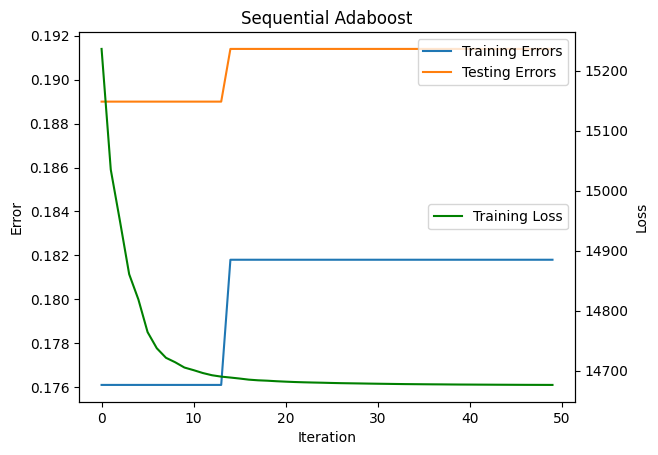

In [19]:
fig, ax = plt.subplots()
ax.plot(s_errors_train, label="Training Errors")
ax.plot(s_errors_test, label="Testing Errors")
ax.set_xlabel("Iteration")
ax.set_ylabel("Error")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(s_loss, label="Training Loss", color="green")
ax2.set_ylabel("Loss")
ax2.legend(loc='center right')

plt.title("Sequential Adaboost")
plt.show()